### Zip Codes to Focus on

In [24]:
zip_codes_to_keep = ['29401', '29402', '29403', '29404', '29405', '29406', '29407', '29409', '29412', '29413', '29414', '29415', 
                    '29416', '29417', '29418', '29419', '29420', '29422', '29423', '29424', '29425', '29426', '29429', '29438', 
                    '29439', '29449', '29451', '29455', '29456', '29457', '29458', '29464', '29465', '29466', '29470', '29482', 
                    '29487']

### Read in Data Arrest Data

In [50]:
import pandas as pd
import numpy as np

pd.set_option('display.width', 1000)

arrests_2015 = pd.read_csv("2015_Arrests.csv")
arrests_2016 = pd.read_csv("2016_Arrests.csv")
arrests_2017 = pd.read_csv("2017_Arrests.csv")
arrests_2018 = pd.read_csv("2018Arrests_YTD_0_2.csv")
arrests_2019 = pd.read_csv("2019Arrests_YTD_0_2.csv")
arrests_2020 = pd.read_csv("2020_Arrests_0_3.csv")
arrests_2021 = pd.read_csv("2021Arrests_YTD_0_3.csv")
arrests_2022 = pd.read_csv("2022Arrests_YTD_0_2.csv")
arrests_2023 = pd.read_csv("2023_Arrests_0_1.csv")
arrests_2024 = pd.read_csv("2024Arrests_YTD_0_3.csv")

combined_arrest_df = pd.concat(
    [
        arrests_2015,
        arrests_2016,
        arrests_2017,
        arrests_2018,
        arrests_2019,
        arrests_2020,
        arrests_2021,
        arrests_2022,
        arrests_2023,
        arrests_2024,
    ]
)

### Get Weather Data

In [26]:
import requests

# Set coordinates and date range
latitude = 32.7765
longitude = -79.9311
start_date = "2015-01-01"
end_date = "2024-12-31"

# Define weather parameters
weather_url = (
    f"https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={latitude}&longitude={longitude}"
    f"&start_date={start_date}&end_date={end_date}"
    f"&daily=temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max"
    f"&timezone=America%2FNew_York"
)

# Request and parse response
response = requests.get(weather_url)
weather_data = response.json()

# Convert to DataFrame
weather_df = pd.DataFrame(weather_data['daily'])

# Convert 'time' to datetime
weather_df['time'] = pd.to_datetime(weather_df['time'])
weather_df.rename(columns={'time': 'date'}, inplace=True)

# Create 'week_start' to join with crime data
weather_df['week_start'] = weather_df['date'] - pd.to_timedelta(weather_df['date'].dt.dayofweek, unit='d')

# Aggregate to weekly level
weather_df_weekly = weather_df.groupby('week_start').agg({
    'temperature_2m_max': 'mean',
    'temperature_2m_min': 'mean',
    'precipitation_sum': 'sum',
    'windspeed_10m_max': 'mean'
}).reset_index()

weather_df_weekly = weather_df_weekly.rename(columns={
    'week_start': 'week_start',
    'temperature_2m_max': 'temp_max',
    'temperature_2m_min': 'temp_min',
    'precipitation_sum': 'precip_total',
    'windspeed_10m_max': 'wind_max'
    })

weather_df_weekly.head()

,week_start,temp_max,temp_min,precip_total,wind_max
0,2014-12-29,17.825000,11.275000,6.7,17.075000
1,2015-01-05,11.914286,3.228571,0.3,24.000000
2,2015-01-12,13.542857,7.485714,25.0,17.785714
3,2015-01-19,17.042857,8.485714,48.1,21.671429
4,2015-01-26,11.657143,4.271429,1.9,22.128571


### Arrest Data Cleaning

In [27]:
# Change zip to string and filter to zip codes of interest
combined_arrest_df['zip'] = combined_arrest_df['zip'].astype(str)
combined_arrest_df = combined_arrest_df[combined_arrest_df['zip'].isin(zip_codes_to_keep)]
print(combined_arrest_df.head())

   FID  ArrestID Arrest_Dat  ArrestTime streetnbr                    street               city state    zip  Name_ID  age race sex Team Beat           X          Y recblock                     charge  x2  y2
0    1     59916    7/26/15         254        29  MAGNOLIA RD/TALL OAK AVE         CHARLESTON    SC  29407   157815   27    B   M   T4  425  2311413.50  346924.91           SIMPLE POSS MARIJUANA 1ST NaN NaN
1    2     63352   12/15/15        2320         1      SPRING ST/MEETING ST         CHARLESTON    SC  29403    28389   62    B   M   T1  122  2325981.75  351230.28              OPEN CONTAINER ALCOHOL NaN NaN
2    3     59917    7/26/15         327         0      SC30/CALHOUN ST RAMP         CHARLESTON    SC  29401   330070   21    W   M   T2  224  2322320.50  346668.19                             DUI 2ND NaN NaN
3    4     63353   12/16/15          47         0        MAIN RD/CHISOLM RD  CHARLESTON COUNTY    SC  29455    39583   20    B   M   T4  433  2274725.50  345153.09     

In [28]:
# Change arrest date to datetime
combined_arrest_df['Arrest_Dat'] = pd.to_datetime(combined_arrest_df['Arrest_Dat'], errors='coerce')

/var/folders/fc/cx28m5b92sg_cdzb4tf5j9800000gn/T/ipykernel_3464/3390859828.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_arrest_df['Arrest_Dat'] = pd.to_datetime(combined_arrest_df['Arrest_Dat'], errors='coerce')


In [29]:
# Function to properly format time
def format_time(time_str):
    # Convert to string and pad with zeros if needed
    time_str = str(time_str).zfill(4)
    
    # Extract hours and minutes
    if len(time_str) <= 4:
        hours = int(time_str[:-2])
        minutes = int(time_str[-2:])
        
        # Handle cases where hours might be > 24
        if hours >= 24:
            hours = hours % 24
            
        # Format time properly
        return f"{hours:02d}:{minutes:02d}"
    return None


combined_arrest_df['ArrestTime'] = combined_arrest_df['ArrestTime'].apply(format_time)
print(combined_arrest_df['ArrestTime'].head())


0    02:54
1    23:20
2    03:27
3    00:47
4    09:47
Name: ArrestTime, dtype: object


In [30]:
# Filter to zip codes with 20 or more arrests
# Count arrests per zip
zip_counts = combined_arrest_df.groupby('zip').size()
# Get zip codes with 20 or more arrests
valid_zips = zip_counts[zip_counts >= 20].index
# Filter the dataframe to keep only those zip codes
combined_arrest_df = combined_arrest_df[combined_arrest_df['zip'].isin(valid_zips)]

In [31]:
# Drop unnecessary columns
combined_arrest_df.drop(columns=['FID', 'ArrestID', 'Name_ID', 'x2', 'y2', 'state', 'Team', 'Beat', 'streetnbr', 'street', 'recblock', 'charge', 'age', 'race', 'sex'], inplace=True)
print(combined_arrest_df.head())

  Arrest_Dat ArrestTime               city    zip           X          Y
0 2015-07-26      02:54         CHARLESTON  29407  2311413.50  346924.91
1 2015-12-15      23:20         CHARLESTON  29403  2325981.75  351230.28
2 2015-07-26      03:27         CHARLESTON  29401  2322320.50  346668.19
3 2015-12-16      00:47  CHARLESTON COUNTY  29455  2274725.50  345153.09
4 2015-07-26      09:47         CHARLESTON  29403  2325832.75  353010.72


In [32]:
combined_arrest_df['week_start'] = combined_arrest_df['Arrest_Dat'] - pd.to_timedelta(combined_arrest_df['Arrest_Dat'].dt.dayofweek, unit='d')
combined_arrest_df["week_arrests"] = combined_arrest_df.groupby(['week_start', 'zip'])['Arrest_Dat'].transform('count')
# Drop city column
combined_arrest_df = combined_arrest_df.drop(columns=['city'])

print(combined_arrest_df.head())



  Arrest_Dat ArrestTime    zip           X          Y week_start  week_arrests
0 2015-07-26      02:54  29407  2311413.50  346924.91 2015-07-20            26
1 2015-12-15      23:20  29403  2325981.75  351230.28 2015-12-14            61
2 2015-07-26      03:27  29401  2322320.50  346668.19 2015-07-20            31
3 2015-12-16      00:47  29455  2274725.50  345153.09 2015-12-14            11
4 2015-07-26      09:47  29403  2325832.75  353010.72 2015-07-20            52


### Combine Arrests and Weather Data

In [33]:
# Combined Data
combined_df = pd.merge(
    combined_arrest_df,
    weather_df_weekly,
    on="week_start",
    how="inner"  # only keep weeks that exist in both datasets
)
print(len(combined_df))
print(combined_df.isnull().sum())

combined_df.to_csv('arrest_weather_data.csv', index=False)


47799
Arrest_Dat      0
ArrestTime      0
zip             0
X               0
Y               0
week_start      0
week_arrests    0
temp_max        0
temp_min        0
precip_total    0
wind_max        0
dtype: int64


### Feature Engineering

In [35]:
import pandas as pd
pd.set_option('display.width', 1000)


df = pd.read_csv('arrest_weather_data.csv')

# Convert date fields to datetime (should already be, but making sure)
df['Arrest_Dat'] = pd.to_datetime(df['Arrest_Dat'])
df['week_start'] = pd.to_datetime(df['week_start'])

# Aggregate data at weekly + zip code level
weekly_zip_df = df.groupby(['week_start', 'zip']).agg(
    week_arrests=('week_arrests', 'first'), 
    avg_temp_max=('temp_max', 'first'),
    avg_temp_min=('temp_min', 'first'),
    total_precip=('precip_total', 'first'),
    avg_wind_max=('wind_max', 'first'),
).reset_index()

# Create time-based features
weekly_zip_df["year"] = weekly_zip_df["week_start"].dt.year
weekly_zip_df["month"] = weekly_zip_df["week_start"].dt.month
weekly_zip_df["week_of_year"] = weekly_zip_df["week_start"].dt.isocalendar().week
weekly_zip_df["quarter"] = weekly_zip_df["week_start"].dt.quarter

# Create interaction features
weekly_zip_df["temp_range"] = weekly_zip_df["avg_temp_max"] - weekly_zip_df["avg_temp_min"]
weekly_zip_df["temp_precip_interaction"] = weekly_zip_df["avg_temp_max"] * weekly_zip_df["total_precip"]


# Rolling average features
weekly_zip_df["rolling_4w_arrests"] = (weekly_zip_df.groupby("zip")["week_arrests"].rolling(4, min_periods=1).mean().reset_index(0, drop=True))
weekly_zip_df["rolling_8w_arrests"] = (weekly_zip_df.groupby("zip")["week_arrests"].rolling(8, min_periods=1).mean().reset_index(0, drop=True))
weekly_zip_df["rolling_12w_arrests"] = (weekly_zip_df.groupby("zip")["week_arrests"].rolling(12, min_periods=1).mean().reset_index(0, drop=True))

# Create lag features
weekly_zip_df["lag_1_arrests"] = weekly_zip_df.groupby("zip")["week_arrests"].shift(1)
weekly_zip_df["lag_2_arrests"] = weekly_zip_df.groupby("zip")["week_arrests"].shift(2)
weekly_zip_df["lag_3_arrests"] = weekly_zip_df.groupby("zip")["week_arrests"].shift(3)
weekly_zip_df["lag_4_arrests"] = weekly_zip_df.groupby("zip")["week_arrests"].shift(4)

# Create seasonal features
weekly_zip_df["is_summer"] = weekly_zip_df["month"].isin([6, 7, 8]).astype(int)
weekly_zip_df["is_winter"] = weekly_zip_df["month"].isin([12, 1, 2]).astype(int)

# One-hot encode categorical variables
weekly_zip_df = pd.get_dummies(weekly_zip_df, columns=["month", "zip", "quarter"], drop_first=True)

# Drop rows with NaNs values
weekly_zip_df.dropna(inplace=True)
print(weekly_zip_df.head())

# Save it to a csv
weekly_zip_df.to_csv('weekly_zip_arrest.csv')


   week_start  week_arrests  avg_temp_max  avg_temp_min  total_precip  avg_wind_max  year  week_of_year  temp_range  temp_precip_interaction  rolling_4w_arrests  rolling_8w_arrests  rolling_12w_arrests  lag_1_arrests  lag_2_arrests  lag_3_arrests  lag_4_arrests  is_summer  is_winter  month_2  month_3  month_4  month_5  month_6  month_7  month_8  month_9  month_10  month_11  month_12  zip_29403  zip_29405  zip_29406  zip_29407  zip_29412  zip_29414  zip_29418  zip_29455  zip_29464  quarter_2  quarter_3  quarter_4
29 2015-01-26            27     11.657143      4.271429           1.9     22.128571  2015             5    7.385714                22.148571               24.50                23.4                 23.4           18.0           25.0           28.0           19.0          0          1    False    False    False    False    False    False    False    False     False     False     False      False      False      False      False      False      False      False      False      Fal

### Model Assembly, Training and Evaluation

#### XGBoost and Random Forest Models

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

data = pd.read_csv('weekly_zip_arrest.csv')

# Define features and target
X = data.drop(columns=["week_arrests", "week_start"])
y = data["week_arrests"]

# Split data such that 2023-2024 is used for testing
train_size = int(len(data) * 0.8)
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]


# Scale features
scaler = RobustScaler()  # Apparantly this is more robust to outliers than StandardScaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    "XGBoost": xgb.XGBRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42)
}

# Define parameter grids for each model
param_grids = {
    "XGBoost": {
        "n_estimators": [200, 300],
        "max_depth": [3, 5],
        "learning_rate": [0.1, 0.2],
        "subsample": [0.8, 0.9, 1.0],
        "colsample_bytree": [0.9, 1.0],
        "min_child_weight": [3, 5],
    },
    "RandomForest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2, 4],
    }
}

# Train and evaluate models
best_model = None
best_score = float("-inf")
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Use TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=5) # This preserves the chronological order of the data which is important for trends/seasonality

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=tscv,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=1,
    )

    grid_search.fit(X_train_scaled, y_train)

    # Get best model and make predictions
    best_estimator = grid_search.best_estimator_
    y_pred = best_estimator.predict(X_test_scaled)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "best_params": grid_search.best_params_,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "model": best_estimator,
    }

    print(f"\nBest parameters for {name}: {grid_search.best_params_}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.2f}")



Training XGBoost...
Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}
RMSE: 3.09
MAE: 1.42
R2 Score: 0.95

Training RandomForest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters for RandomForest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
RMSE: 4.14
MAE: 2.11
R2 Score: 0.92


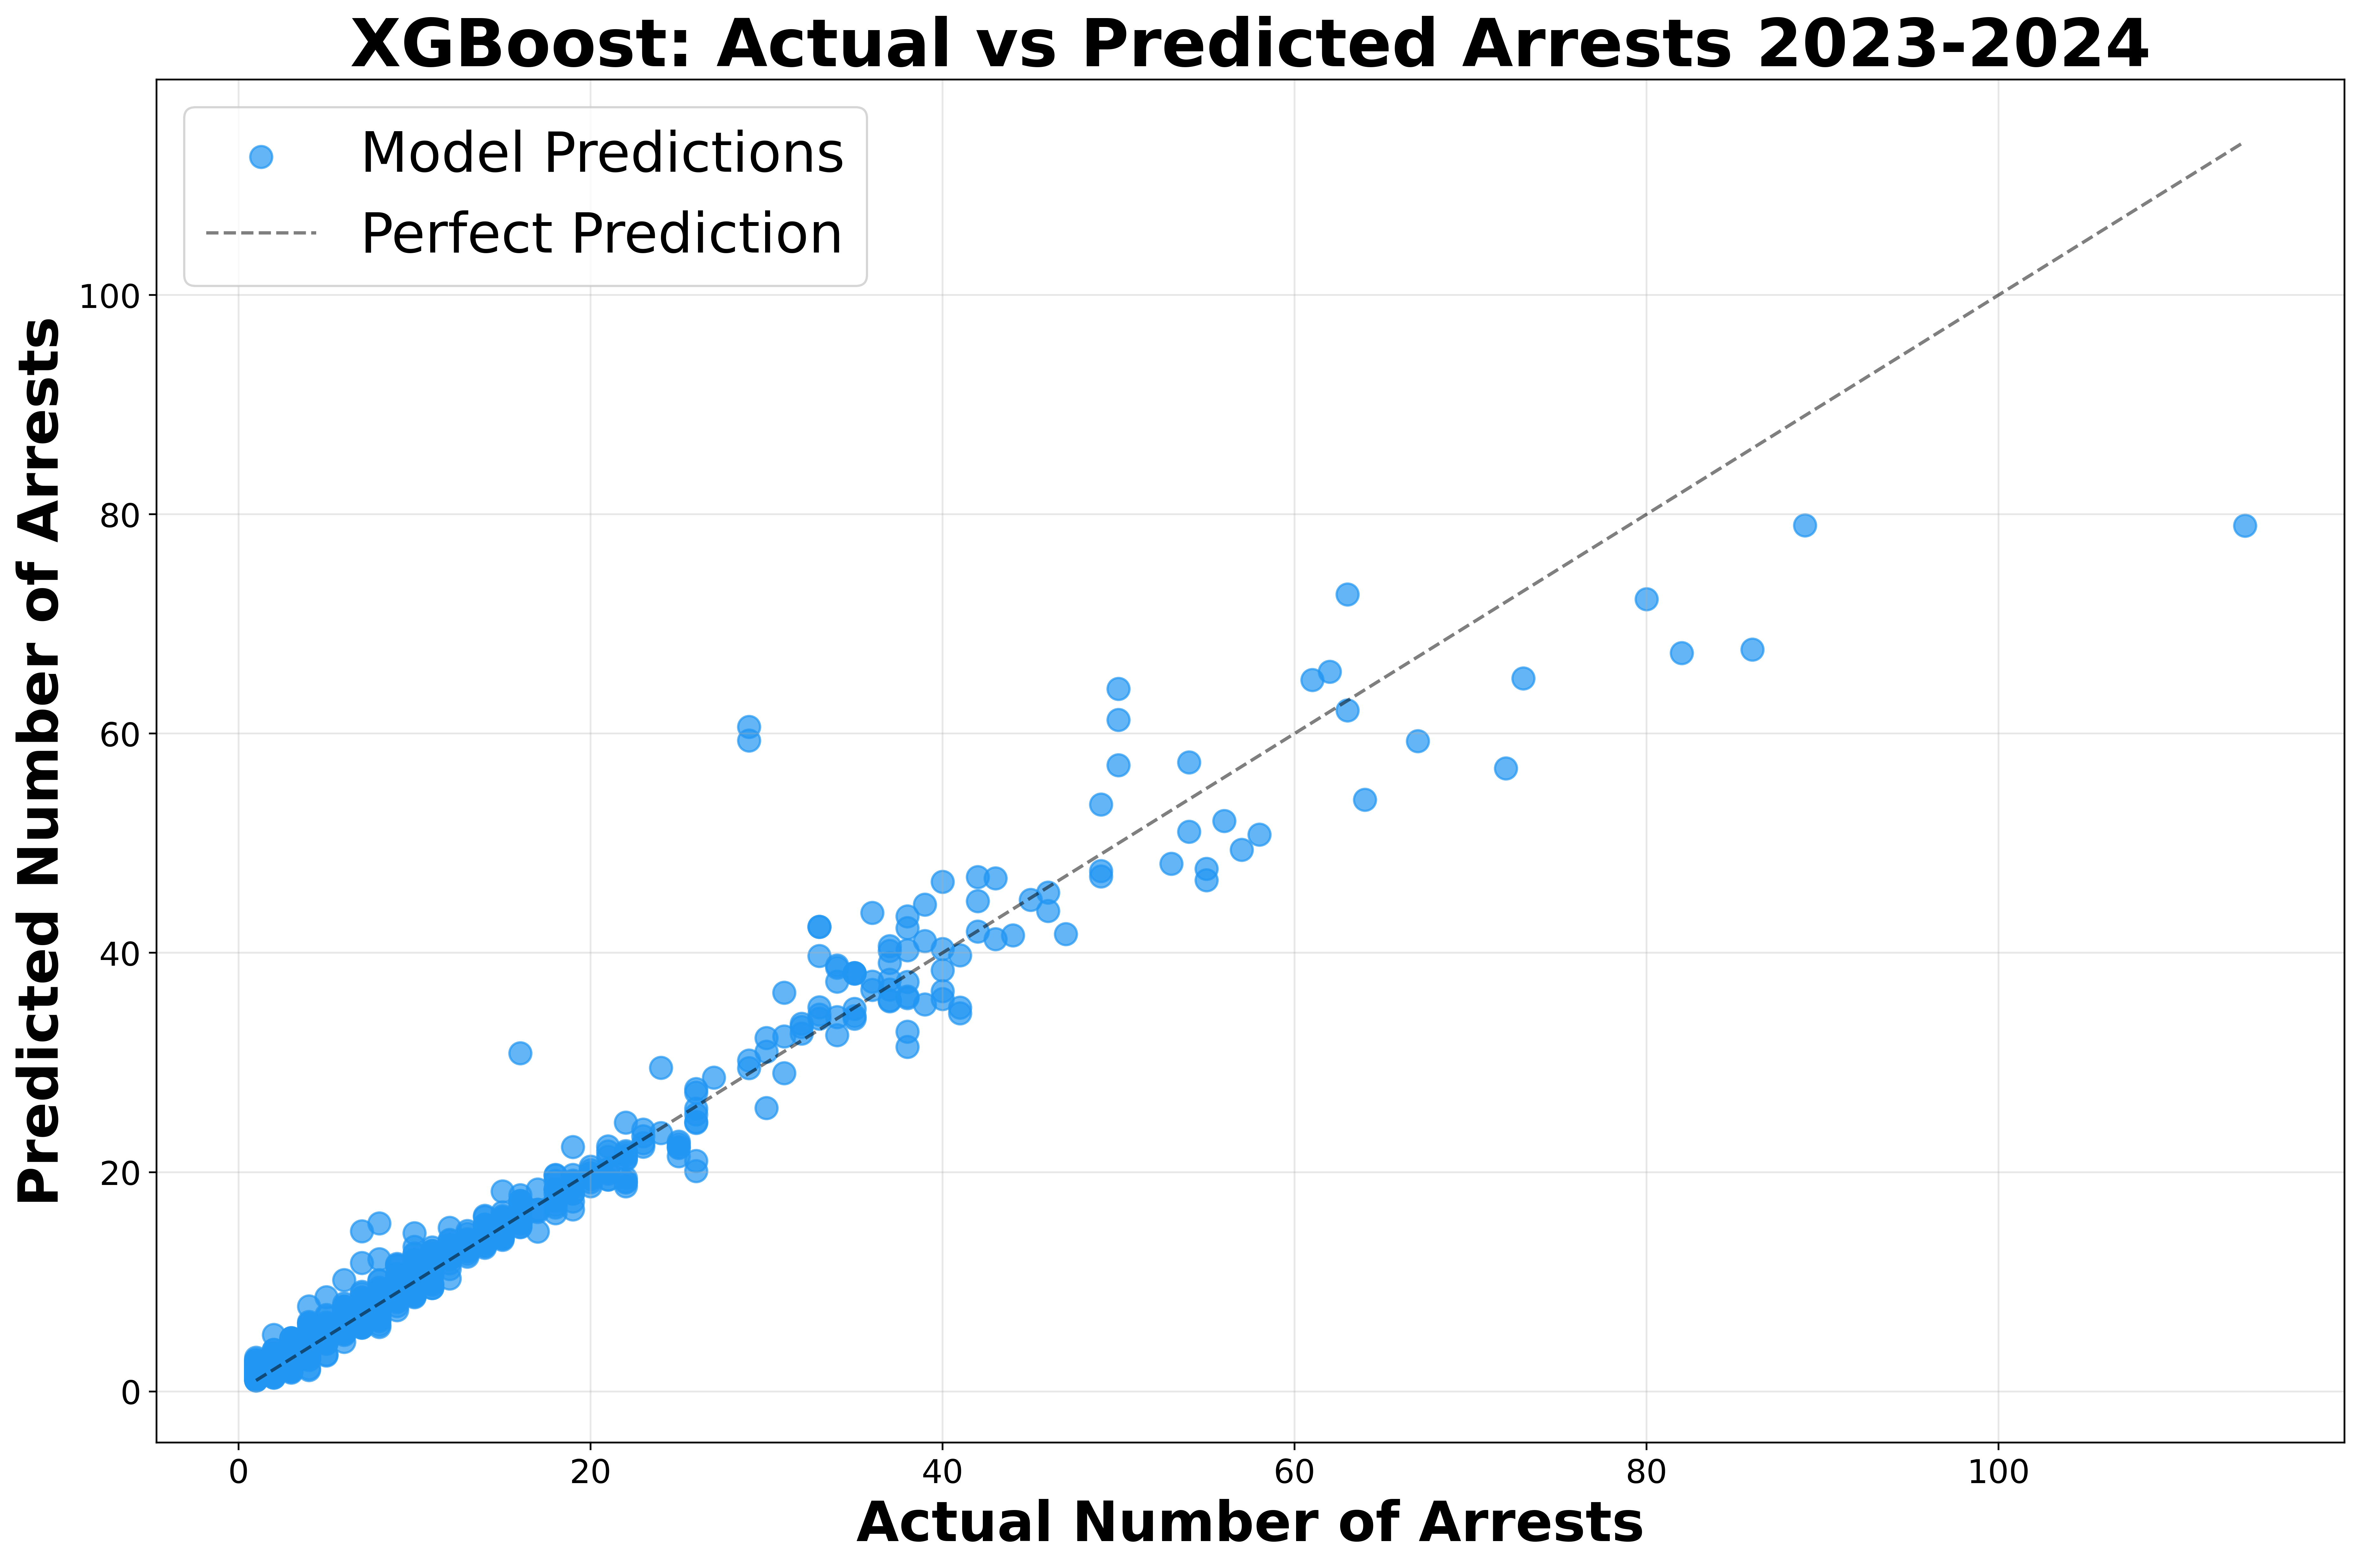

In [ ]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted values for the XGBoost model
plt.subplots(figsize=(15, 10), dpi=500)
# Create scatter plot
scatter = plt.scatter(y_test.values, 
                     results["XGBoost"]["model"].predict(X_test_scaled),
                     color='#2196F3',
                     alpha=0.7,
                     s=100, 
                     label='Model Predictions')

# Add a diagonal line for perfect prediction
min_val = min(min(y_test.values), min(results["XGBoost"]["model"].predict(X_test_scaled)))
max_val = max(max(y_test.values), max(results["XGBoost"]["model"].predict(X_test_scaled)))
line = plt.plot([min_val, max_val], [min_val, max_val], 
                'k--',
                alpha=0.5,
                label='Perfect Prediction')

plt.title('XGBoost: Actual vs Predicted Arrests 2023-2024', fontsize=30, fontweight='bold')
plt.xlabel('Actual Number of Arrests', fontsize=25, fontweight='bold')
plt.xticks(fontsize=15)
plt.ylabel('Predicted Number of Arrests', fontsize=25, fontweight='bold')
plt.yticks(fontsize=15)
plt.legend(fontsize=25)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Prophet Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Read the data
data = pd.read_csv('weekly_zip_arrest.csv')

# Define features and target
# Dropping the rolling and lag features because they are not useful for the Prophet model
X = data.drop(columns=["week_arrests", "week_start", "rolling_4w_arrests", "rolling_8w_arrests", "rolling_12w_arrests", "lag_1_arrests", "lag_2_arrests", "lag_3_arrests", "lag_4_arrests"])
y = data["week_arrests"]

# Split data such that 2023-2024 is used for testing
train_size = int(len(data) * 0.8)
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled features back to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Prepare data for Prophet
prophet_train = pd.DataFrame({
    "ds": pd.to_datetime(data.iloc[:train_size]["week_start"]),
    "y": y_train
})

# Add scaled regressors
for col in X_train.columns:
    prophet_train[col] = X_train_scaled_df[col].values

# Initialize and configure Prophet model
prophet_model = Prophet(
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=0.1,
    seasonality_mode='additive',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Add regressors
for col in X_train.columns:
    prophet_model.add_regressor(col)

# Fit the model
prophet_model.fit(prophet_train)

# Prepare test data with scaled features
prophet_test = pd.DataFrame({
    "ds": pd.to_datetime(data.iloc[train_size:]["week_start"])
})
for col in X_test.columns:
    prophet_test[col] = X_test_scaled_df[col].values

# Make predictions
forecast = prophet_model.predict(prophet_test)
y_pred = forecast["yhat"].values

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Prophet Model Metrics")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")

21:58:31 - cmdstanpy - INFO - Chain [1] start processing
21:58:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Metrics
RMSE: 6.89
MAE: 4.20
R2 Score: 0.77


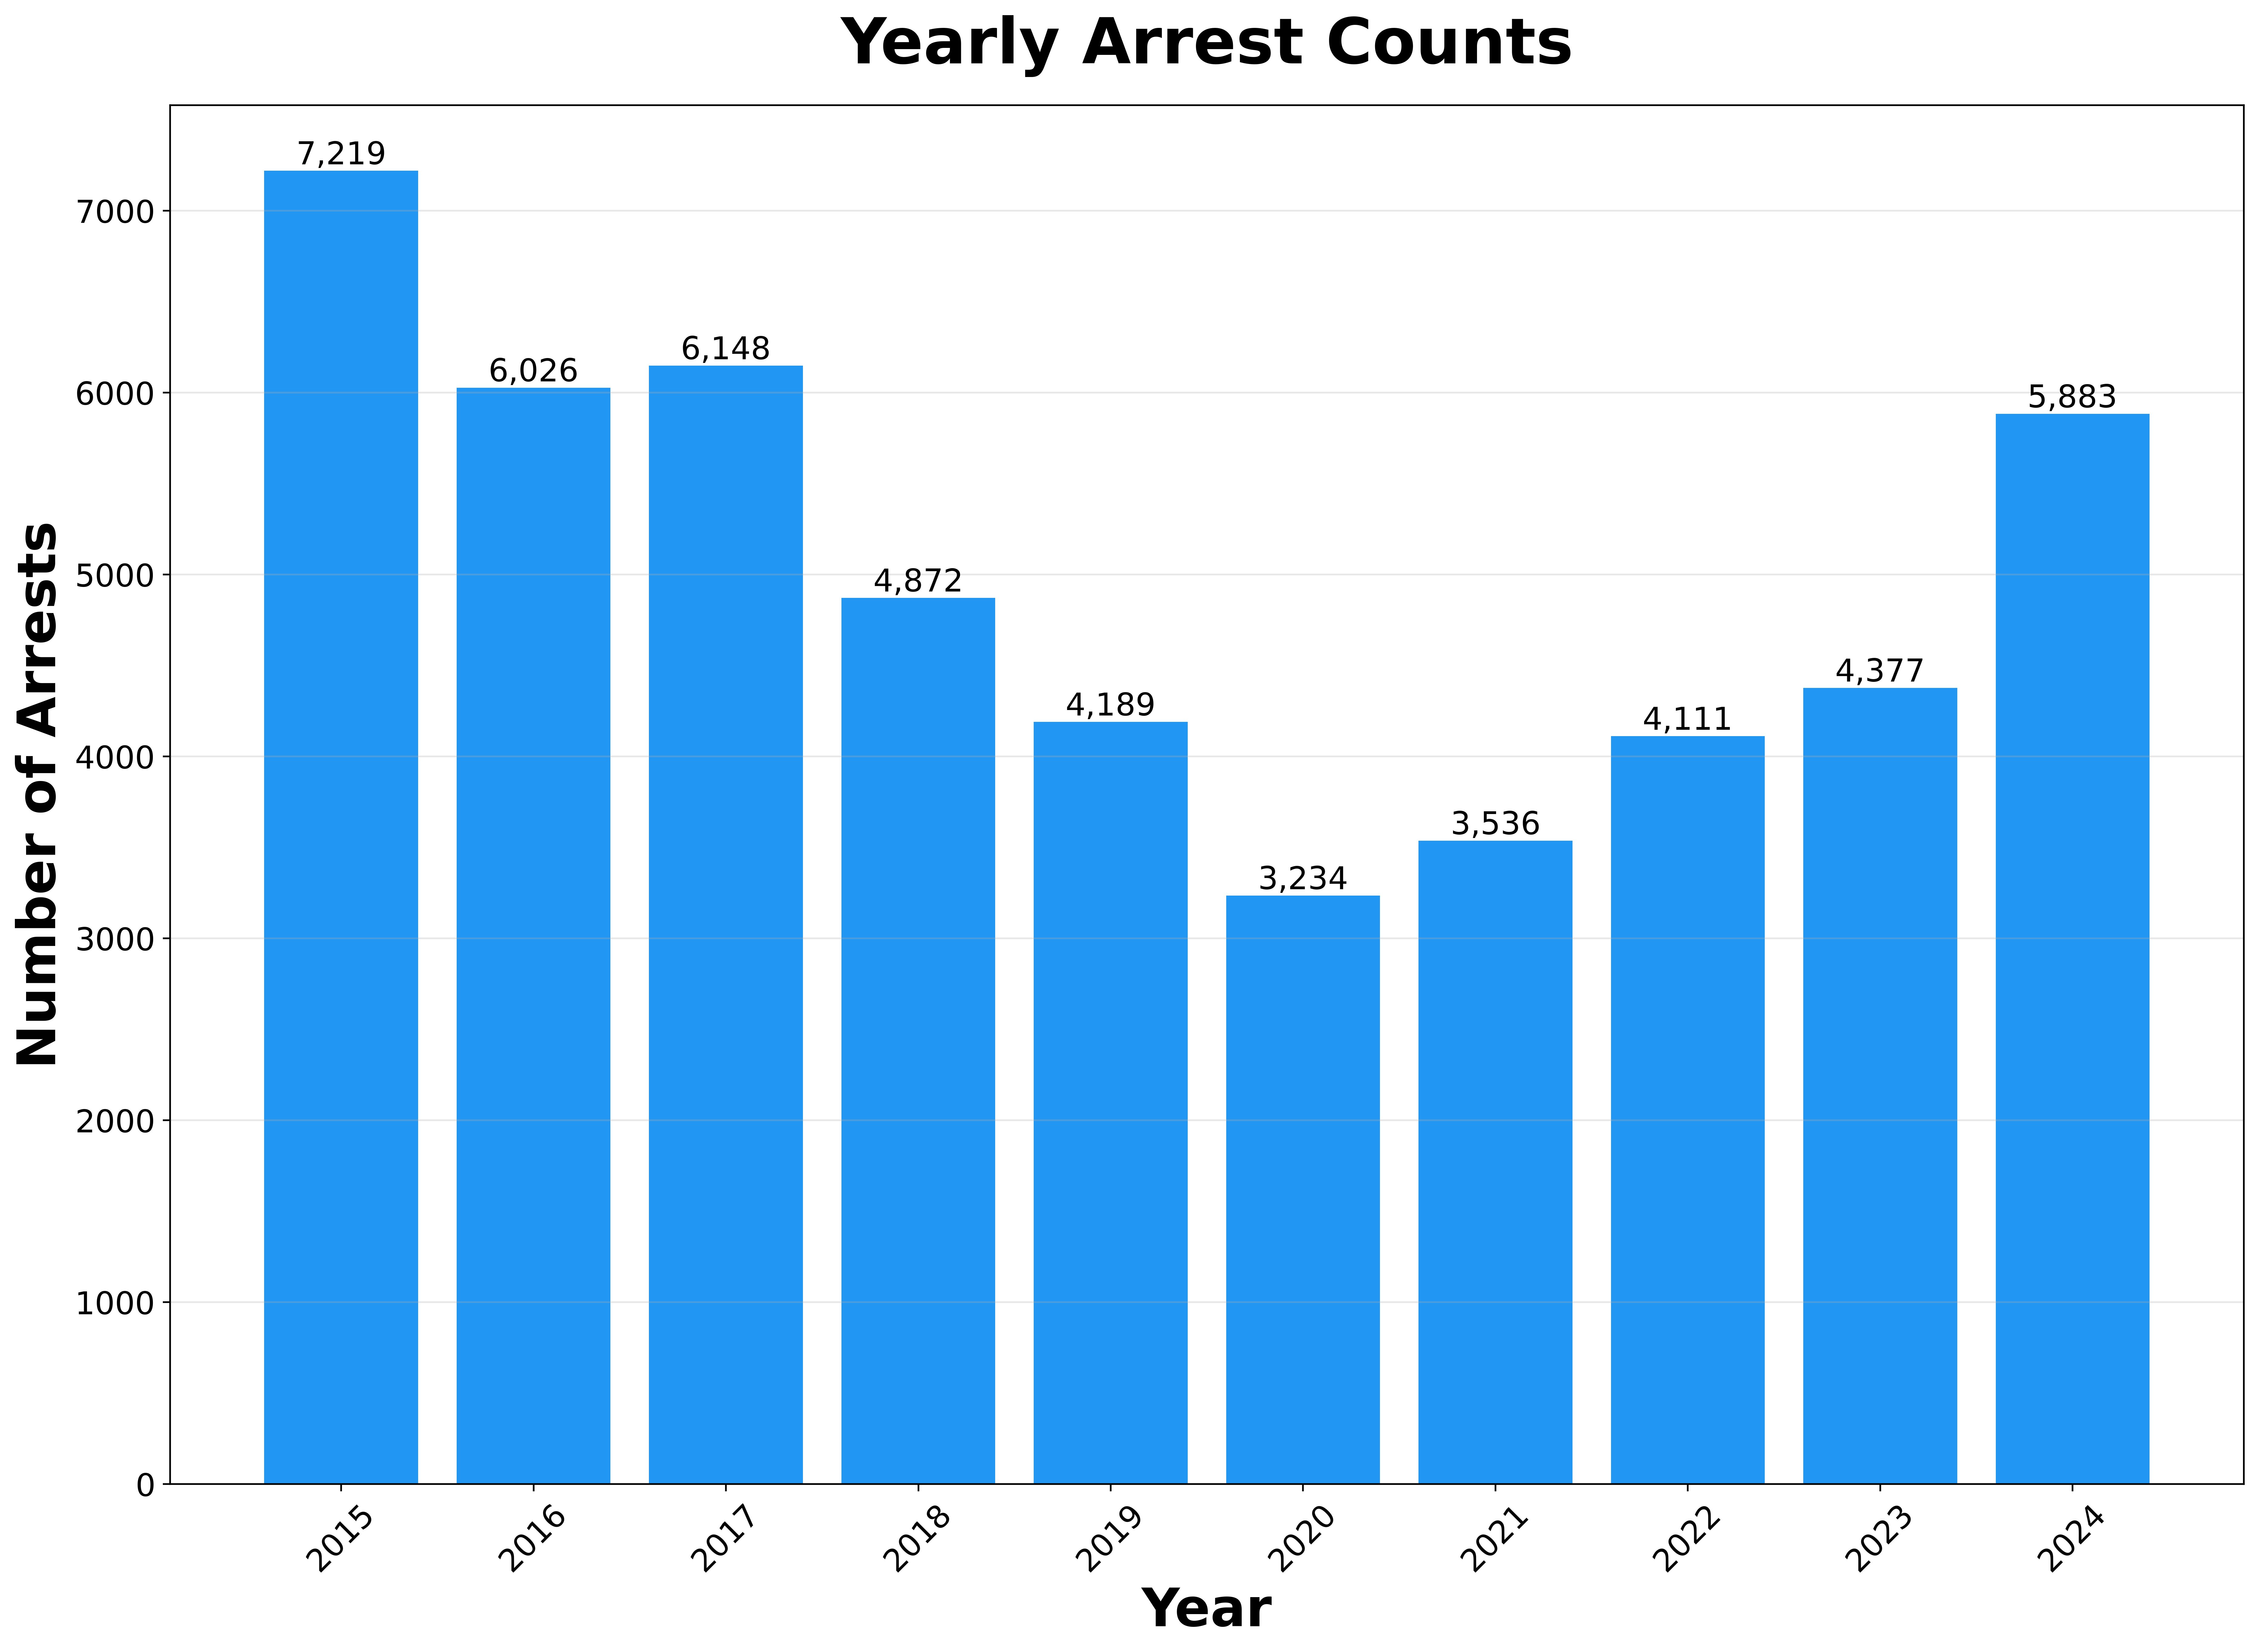

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


combined_arrest_df = pd.DataFrame(combined_arrest_df)

combined_arrest_df['Arrest_Dat'] = pd.to_datetime(combined_arrest_df['Arrest_Dat'])
combined_arrest_df = combined_arrest_df[combined_arrest_df['Arrest_Dat'] >= '2015-01-01']
combined_arrest_df = combined_arrest_df[combined_arrest_df['Arrest_Dat'] <= '2024-12-31']
# Extract year and count arrests per year
yearly_counts = combined_arrest_df.groupby(combined_arrest_df['Arrest_Dat'].dt.year).size()

# Create bar chart to show yearly arrests trends
plt.figure(figsize=(15, 11), dpi=500)
bars = plt.bar(yearly_counts.index, yearly_counts.values, color='#2196F3')

# Add value labels at the top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{int(height):,}',
             ha='center', va='bottom',
             fontsize=15)

plt.title('Yearly Arrest Counts', pad=20, fontsize=30, fontweight='bold')
plt.xlabel('Year', fontsize=25, fontweight='bold')
plt.ylabel('Number of Arrests', fontsize=25, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.xticks(yearly_counts.index, yearly_counts.index, fontsize=15, rotation=45)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.show()